# Site and user analysis

Considering only sites with at least 5 updates that started since Jan 2013....
 - What percent of sites have posts from multiple userIds?
 - What percent of sites have posts from patients and caregivers?
 - What percent of users have posts on multiple sites?
 - What percent of users have posts from patients and caregivers?
 
 
#### Summary of results
 
Considering only the 99,021 CaringBridge sites created since January 2013 with more than 5 journal updates, 37% of sites contain updates from both patients and caregivers.  However, only 25% of sites contain updates authored by multiple registered CaringBridge _accounts_.

Of users who have authored updates for these selected sites, only a tiny minority author updates on more than one site: 1.32% author updates on multiple sites.  However, 30% of users have authored both patient and caregiver updates, which indicates potential multi-use of the account. 

#### Raw results
```
Sites with multiple authoring users: 51672 / 486704 = 10.62%
Sites with posts from patients AND caregivers: 129336 / 486704 = 26.57%
Users with authorship on multiple sites: 16437 / 524123 = 3.14%
Users with posts from patients AND caregivers: 133180 / 524123 = 25.41%

Selected 99021 / 486704 sites = 20.35%

Selected sites with multiple authoring users: 24350 / 99021 = 24.59%
Selected sites with posts from patients AND caregivers: 36775 / 99021 = 37.14%
Users (only on selected sites) with authorship on multiple sites: 1725 / 130399 = 1.32%
Users (only on selected sites) with posts from patients AND caregivers: 39427 / 130399 = 30.24%
```

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split

from collections import Counter
import sqlite3
from nltk import word_tokenize
from html.parser import HTMLParser
from tqdm import tqdm
import random
import pickle

from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

In [3]:
general_working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type"
vw_working_dir = os.path.join(general_working_dir, "vw")
os.makedirs(vw_working_dir, exist_ok=True)

In [4]:
#%%time
# read the dataframe
journal_df_filepath = os.path.join(vw_working_dir, "journal_author_metadata.csv")
journal_df = pd.read_csv(journal_df_filepath)
print(len(journal_df))

14970549


In [5]:
journal_df.head()

,Unnamed: 0,site_id,journal_oid,author_type_raw_prediction,author_type_prediction_prob,is_predicted_patient,created_at,site_index,user_id
0,7874,1,51bdf3e56ca0048f4e00ce76,-5.555666,0.003851,False,1117944720000,47,1
1,7876,1,51bdf3e56ca0048f4e00ce78,-4.185403,0.014988,False,1117764480000,46,1
2,7878,1,51bdf3e56ca0048f4e00ce7a,-2.417768,0.081828,False,1117675380000,45,1
3,7880,1,51bdf3e56ca0048f4e00ce7c,-3.126491,0.042028,False,1117572600000,44,1
4,7882,1,51bdf3e56ca0048f4e00ce7e,-2.294478,0.091581,False,1117485180000,43,1


In [6]:
j_df = journal_df

## User analysis

Includes all users and sites.

In [21]:
multiple_sites = 0
multiple_authors = 0
total_users = 0
for user, group in tqdm(j_df.groupby(by='user_id', sort=False)):
    total_users += 1
    site_ids = set(group.site_id)
    if len(site_ids) > 1:
        multiple_sites += 1
    proportion_patient = np.sum(group.is_predicted_patient) / len(group)
    if proportion_patient >= 0.1 and proportion_patient <= 0.9:
        multiple_authors += 1
total_users

100%|██████████| 524123/524123 [05:32<00:00, 1578.41it/s]


524123

In [22]:
print(f"Users with authorship on multiple sites: {multiple_sites} / {total_users} = {multiple_sites / total_users * 100:.2f}%")
print(f"Users with posts from patients AND caregivers: {multiple_authors} / {total_users} = {multiple_authors / total_users * 100:.2f}%")

Users with authorship on multiple sites: 16437 / 524123 = 3.14%
Users with posts from patients AND caregivers: 133180 / 524123 = 25.41%


## Site analysis

Analyzes all sites and users authoring for those sites.

In [27]:
jan_2013 = 1356998400000

In [37]:
multiple_users = 0
multiple_author_types = 0
total_sites = 0
selected_site_ids = set()
for site_id, group in tqdm(j_df.groupby(by='site_id', sort=False)):
    if len(group) >= 5 and np.min(group.created_at) >= jan_2013:
        selected_site_ids.add(site_id)
    total_sites += 1
    user_ids = set(group.user_id)
    if len(user_ids) > 1:
        multiple_users += 1
    proportion_patient = np.sum(group.is_predicted_patient) / len(group)
    if proportion_patient >= 0.1 and proportion_patient <= 0.9:
        multiple_author_types += 1
total_sites

100%|██████████| 486704/486704 [05:54<00:00, 1373.39it/s]


486704

In [38]:
print(f"Sites with multiple authoring users: {multiple_users} / {total_sites} = {multiple_users / total_sites * 100:.2f}%")
print(f"Sites with posts from patients AND caregivers: {multiple_author_types} / {total_sites} = {multiple_author_types / total_sites * 100:.2f}%")

Sites with multiple authoring users: 51672 / 486704 = 10.62%
Sites with posts from patients AND caregivers: 129336 / 486704 = 26.57%


In [39]:
print(f"Selected {len(selected_site_ids)} / {total_sites} sites = {len(selected_site_ids) / total_sites * 100:.2f}%")

Selected 99021 / 486704 sites = 20.35%


In [40]:
assert len(selected_site_ids) > 0

In [49]:
0 in selected_site_ids, 1 in selected_site_ids

(False, False)

## Site analysis (using only active and recent sites)

In [83]:
multiple_users = 0
multiple_author_types = 0
total_sites = 0
nonzero_users = j_df[j_df.user_id != 0]
print(f"Using only rows from userId!=0: {len(nonzero_users)} / {len(j_df)}")
for site_id, group in tqdm(nonzero_users.groupby(by='site_id', sort=False)):
    if site_id not in selected_site_ids or site_id == 0:
        continue
    total_sites += 1
    user_ids = set(group.user_id)
    assert 0 not in user_ids
    if len(user_ids) > 1:
        multiple_users += 1
    proportion_patient = np.sum(group.is_predicted_patient) / len(group)
    if proportion_patient >= 0.1 and proportion_patient <= 0.9:
        multiple_author_types += 1
total_sites

Using only rows from userId!=0: 13898071 / 14970549


100%|██████████| 486704/486704 [02:39<00:00, 3049.52it/s]


99021

In [84]:
print(f"Selected sites with multiple authoring users: {multiple_users} / {total_sites} = {multiple_users / total_sites * 100:.2f}%")
print(f"Selected sites with posts from patients AND caregivers: {multiple_author_types} / {total_sites} = {multiple_author_types / total_sites * 100:.2f}%")

Selected sites with multiple authoring users: 24350 / 99021 = 24.59%
Selected sites with posts from patients AND caregivers: 36775 / 99021 = 37.14%


## User analysis (using only active and recent sites)

In [78]:
subset_df = j_df[j_df.site_id.isin(selected_site_ids)]
len(subset_df) / len(j_df)

0.22461460832197938

In [79]:
multiple_sites = 0
multiple_authors = 0
total_users = 0
for user, group in tqdm(subset_df.groupby(by='user_id', sort=False)):
    if user == 0:
        continue
    total_users += 1
    site_ids = set(group.site_id)
    if len(site_ids) > 1:
        multiple_sites += 1
    proportion_patient = np.sum(group.is_predicted_patient) / len(group)
    if proportion_patient >= 0.1 and proportion_patient <= 0.9:
        multiple_authors += 1
total_users

100%|██████████| 130400/130400 [01:17<00:00, 1683.79it/s]


130399

In [80]:
print(f"Users (only on selected sites) with authorship on multiple sites: {multiple_sites} / {total_users} = {multiple_sites / total_users * 100:.2f}%")
print(f"Users (only on selected sites) with posts from patients AND caregivers: {multiple_authors} / {total_users} = {multiple_authors / total_users * 100:.2f}%")

Users (only on selected sites) with authorship on multiple sites: 1725 / 130399 = 1.32%
Users (only on selected sites) with posts from patients AND caregivers: 39427 / 130399 = 30.24%


### Number of sites per user analysis

In [58]:
authored_site_ids = []
extreme_user_ids = []
for user_id, group in tqdm(subset_df.groupby(by='user_id', sort=False)):
    total_users += 1
    site_ids = set(group.site_id)
    authored_site_ids.append(len(site_ids))
    if len(site_ids) > 1000:
        extreme_user_ids.append((user_id, len(site_ids)))
len(authored_site_ids), len(extreme_user_ids)

100%|██████████| 130400/130400 [00:47<00:00, 2754.86it/s]


(130400, 1)

In [59]:
extreme_user_ids

[(0, 5042)]

In [60]:
authored_site_ids = np.array(authored_site_ids)

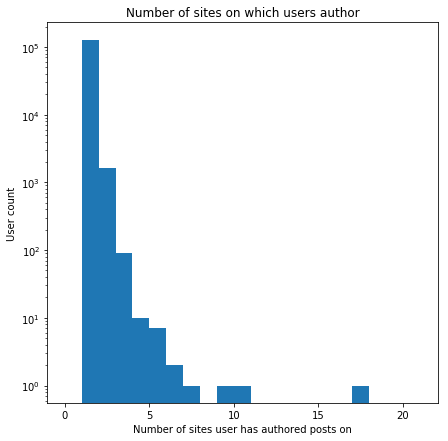

In [73]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.hist(authored_site_ids, log=True, bins=range(0, 22))
ax.set_xlabel("Number of sites user has authored posts on")
ax.set_ylabel("User count")
ax.set_title("Number of sites on which users author")
plt.show()